In [31]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt
%run helpers_preproc.ipynb
#added test

In [32]:
#read in the data, get normalized adjacency (NxN)
mesh_dir = 'SHREC11/'
label_np = np.array(readLbl(mesh_dir+'labels.txt'))

In [33]:
node_sigs_list = []
normed_adjMats_list = []

for i in range(600):
    fName = 'T' + str(i) + '.obj'
    adj_noscale_read = obj_2_adj_noscale(mesh_dir + fName)
    adj_scaled_read = obj_2_adj(mesh_dir + fName)

    if (adj_scaled_read.shape[0] < 252):
        adj_noscale = np.empty([252,252])
        adj_scaled = np.empty([252,252])
    else:
        adj_noscale = adj_noscale_read
        adj_scaled = adj_scaled_read

    adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])

    #node level signal extraction
    node_degs = np.sum(adj_noscale,axis = 0)
    node_neigh_max = np.max(adj_scaled,axis = 0)
    node_neigh_min = np.min(adj_scaled,axis = 0)
    node_neigh_sum = np.sum(adj_scaled,axis = 0)
    node_neigh_mean = np.sum(adj_scaled,axis = 0)

    node_sig = np.stack([node_degs,node_neigh_max,node_neigh_min,node_neigh_sum,node_neigh_mean],axis = 1)
    
    node_sigs_list.append(node_sig)
    normed_adjMats_list.append(adj_normalized)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_16850/2253974103.py:16: RuntimeWarning: invalid value encountered in true_divide
  adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])


In [34]:
normed_adjMats = np.nan_to_num(np.stack(normed_adjMats_list))
node_sigs = np.nan_to_num(np.stack(node_sigs_list))

In [35]:
normed_adjMats_tr = normed_adjMats[:450,:,:]
node_sigs_tr = node_sigs[:450,:,:]
label_np_tr = label_np[:450]

normed_adjMats_ts = normed_adjMats[450:,:,:]
node_sigs_ts = node_sigs[450:,:,:]
label_np_ts = label_np[450:]

label_mat_tr = torch.tensor(np.where(igl.all_pairs_distances(label_np_tr,label_np_tr,False) > 0.5,0,1)).float()
label_mat_ts = torch.tensor(np.where(igl.all_pairs_distances(label_np_ts,label_np_ts,False) > 0.5,0,1)).float()

In [36]:
normed_adjMats_tr = torch.tensor(normed_adjMats_tr).float()
node_sigs_tr = torch.tensor(node_sigs_tr).float()
label_np_tr = torch.tensor(label_np_tr).float()

normed_adjMats_ts = torch.tensor(normed_adjMats_ts).float()
node_sigs_ts = torch.tensor(node_sigs_ts).float()
label_np_ts = torch.tensor(label_np_ts).float()

In [37]:
#label_mat_train = form_label_matrix(label_mat, train_dict)

In [38]:
#normed_adjMats_list_train, node_sigs_list_train = prep_data(train_dict)

In [39]:
#normed_adjMats_train = np.stack(normed_adjMats_list_train)
#node_sigs_train = np.stack(node_sigs_list_train)

#normed_adjMats_train = torch.tensor(normed_adjMats_train,requires_grad=False).float()
#node_sigs_train = torch.tensor(node_sigs_train,requires_grad=False).float()

#normed_adjMats_train = torch.nan_to_num(normed_adjMats_train,0,0,0)
#node_sigs_train = torch.nan_to_num(node_sigs_train,0,0,0)

In [40]:
node_sigs_tr

tensor([[[5.0000, 0.0888, 0.0000, 0.3595, 0.3595],
         [7.0000, 0.1017, 0.0000, 0.4655, 0.4655],
         [6.0000, 0.0920, 0.0000, 0.4395, 0.4395],
         ...,
         [7.0000, 0.1142, 0.0000, 0.5429, 0.5429],
         [6.0000, 0.1352, 0.0000, 0.4959, 0.4959],
         [7.0000, 0.1352, 0.0000, 0.5233, 0.5233]],

        [[5.0000, 0.1061, 0.0000, 0.4014, 0.4014],
         [5.0000, 0.1546, 0.0000, 0.4404, 0.4404],
         [5.0000, 0.2171, 0.0000, 0.5315, 0.5315],
         ...,
         [5.0000, 0.1340, 0.0000, 0.4817, 0.4817],
         [6.0000, 0.1705, 0.0000, 0.7666, 0.7666],
         [5.0000, 0.1284, 0.0000, 0.4872, 0.4872]],

        [[4.0000, 0.1228, 0.0000, 0.3313, 0.3313],
         [5.0000, 0.2132, 0.0000, 0.5203, 0.5203],
         [4.0000, 0.1201, 0.0000, 0.2880, 0.2880],
         ...,
         [5.0000, 0.1041, 0.0000, 0.4604, 0.4604],
         [5.0000, 0.1094, 0.0000, 0.4256, 0.4256],
         [4.0000, 0.0913, 0.0000, 0.3470, 0.3470]],

        ...,

        [[7.0000, 0.

In [42]:
%run NNs.ipynb
g = GCN(5,[5,5,5,5])
n = MLP(252*5,[5,5,5,5])
output1 = g.forward(normed_adjMats_tr,node_sigs_tr)
output2 = n.forward(output1)
print(output1.shape)
print(output2.shape)

torch.Size([450, 252, 5])
torch.Size([450, 5])


In [43]:
def lossF(features,lbl_mat):
    disMat = torch.cdist(features,features)
    sameType = disMat * (lbl_mat-torch.diag(torch.ones(lbl_mat.shape[0])))
    diffType = disMat * (1-lbl_mat)

    diffTypeScaled = diffType * torch.exp(-diffType)
    diffTypeScaledMean = torch.sum(diffTypeScaled)/ torch.count_nonzero(diffTypeScaled)
    diffTypeMean = torch.sum(diffType)/ torch.count_nonzero(diffType)

    sameTypeMean = torch.sum(sameType) / torch.count_nonzero(sameType)
    sameTypeStd = torch.sum((sameType - sameTypeMean)**2) / torch.count_nonzero(sameType)

    print(sameTypeMean.detach().numpy(),diffTypeMean.detach().numpy(),torch.sqrt(sameTypeStd).detach().numpy())
    return  sameTypeMean-diffTypeScaledMean + 0.01 * torch.sqrt(sameTypeStd)

In [ ]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.0001)
for i in range(100000):
    optimizer.zero_grad()
    output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
    loss = lossF(output,label_mat_tr)
    loss.backward()
    optimizer.step()

0.07171784 0.07158109 0.39945474
0.06736775 0.06777477 0.37473565
0.069571964 0.07117091 0.38734552
0.06734457 0.06824516 0.3754077
0.07027699 0.07071099 0.3911908
0.06665436 0.06787021 0.37117904
0.065136746 0.06538217 0.36264554
0.06328404 0.064115226 0.352324
0.06453899 0.0649241 0.35932502
0.06300325 0.06321793 0.35155967
0.06425367 0.06408451 0.35781163
0.0629583 0.06381756 0.35098898
0.059246276 0.060126975 0.3298991
0.056893464 0.057683695 0.31697056
0.059230145 0.05929283 0.3303676
0.05798191 0.058201168 0.3231956
0.058036324 0.05843122 0.32358527
0.058990836 0.05816572 0.32881582
0.055984836 0.0563229 0.31156784
0.053637903 0.05436726 0.29915285
0.05270842 0.053844675 0.2937421
0.054528914 0.05528341 0.30378214
0.054827143 0.055555988 0.30553126
0.054263014 0.055266377 0.30240202
0.053917192 0.054875176 0.30070364
0.049360555 0.050199445 0.2755322
0.048071414 0.048152037 0.26802102
0.048616286 0.049307503 0.27120274
0.05067906 0.05152475 0.2823159
0.048972614 0.04952307 0.2735

0.09577856 0.14981328 0.5363841
0.09623894 0.15024966 0.5386711
0.09447425 0.15152828 0.52920926
0.097405285 0.14983301 0.5448312
0.097859204 0.15406275 0.54808056
0.09973587 0.15117358 0.5581936
0.09894762 0.15423916 0.5537722
0.09768141 0.15215106 0.5465717
0.09716862 0.1518242 0.54395586
0.09729807 0.15052217 0.54441553
0.09665412 0.15189528 0.5408892
0.09554721 0.15206683 0.53531986
0.09675105 0.15227854 0.541984
0.09734895 0.15312074 0.54501796
0.096389115 0.15115859 0.5398342
0.09321286 0.15202393 0.5223662
0.09387085 0.15437771 0.5261679
0.09663491 0.15292966 0.54130673
0.093646996 0.1544173 0.52512944
0.09953552 0.1543111 0.55781955
0.09598198 0.15376401 0.5374805
0.09643122 0.15467761 0.5401501
0.09928507 0.15414271 0.5558902
0.0985886 0.15703048 0.55240256
0.096384495 0.1574438 0.54030776
0.09628533 0.15491171 0.5394509
0.09797185 0.15809727 0.5490943
0.09592614 0.15722302 0.5377638
0.096470304 0.15728082 0.540781
0.095121056 0.15472353 0.5330408
0.09808585 0.1601274 0.549862

0.09755146 0.17162803 0.5482888
0.095995404 0.17219116 0.5401426
0.0963433 0.1702689 0.5419568
0.09708105 0.17174056 0.54596025
0.096590266 0.17048427 0.5434036
0.097337954 0.1706942 0.54750556
0.094996825 0.16899386 0.53446823
0.09359511 0.16754915 0.52671105
0.09621307 0.16931573 0.5411566
0.09480746 0.16929087 0.5336471
0.09363588 0.1676833 0.5269505
0.0947714 0.16892038 0.5334605
0.094259396 0.16892052 0.53057486
0.09713643 0.16948675 0.54634976
0.09790734 0.17128026 0.55061096
0.09602233 0.16978516 0.5401125
0.09637862 0.17132455 0.54223865
0.0962309 0.1712107 0.54137796
0.0976231 0.17223783 0.5490217
0.09809275 0.17262587 0.5516566
0.095568135 0.17176914 0.5376853
0.0974931 0.17264926 0.54830235
0.09622085 0.17154527 0.54130524
0.09608124 0.17282863 0.54074055
0.09700212 0.17200075 0.54568005
0.09616885 0.17175196 0.541169
0.096462265 0.17089428 0.54284894
0.09550581 0.17251168 0.53794163
0.09633003 0.17192805 0.5421258
0.0963517 0.17071076 0.54201686
0.09680972 0.1706256 0.54464

In [241]:
output = n.forward(g.forward(normed_adjMats_tr,node_sigs_tr))
output.shape

torch.Size([450, 5])

In [242]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_tr - torch.diag(torch.ones(450)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_tr,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_15013/1443986374.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_tr - torch.diag(torch.ones(450)),dtype=bool).flatten()
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_15013/1443986374.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_tr,dtype=bool).flatten()


0.37953505 0.09957457


Text(0.5, 1.0, 'Diff Comp')

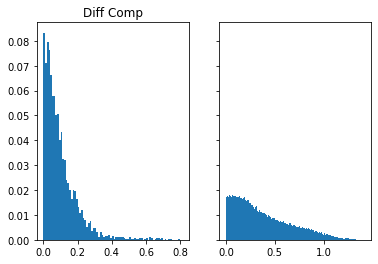

In [243]:
print(np.mean(diffComp),np.mean(sameComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax1.set_title('Diff Comp')

In [244]:
output = n.forward(g.forward(normed_adjMats_ts,node_sigs_ts))
output.shape

torch.Size([150, 5])

In [245]:
disMat = torch.cdist(output,output).flatten()
mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(150)),dtype=bool).flatten()
mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()
sameComp = disMat[mask_same].detach().numpy()
diffComp = disMat[mask_diff].detach().numpy()
weightsSame = np.ones_like(sameComp) / len(sameComp)
weightsDiff = np.ones_like(diffComp) / len(diffComp)

/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_15013/3817663312.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_same = torch.tensor(label_mat_ts - torch.diag(torch.ones(150)),dtype=bool).flatten()
/var/folders/t4/vdzymfw562g8ml8ks_2b5l5r0000gn/T/ipykernel_15013/3817663312.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_diff = torch.tensor(1 - label_mat_ts,dtype=bool).flatten()


0.32389745 0.19046603


Text(0.5, 1.0, 'Diff Comp')

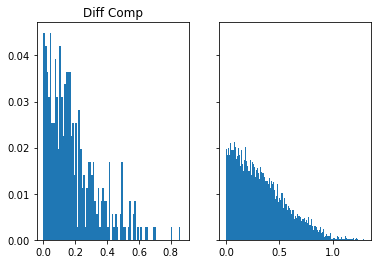

In [246]:
print(np.mean(diffComp),np.mean(sameComp))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sameComp,bins=np.arange(0,np.max(sameComp),0.01),weights=weightsSame,log = False)
ax1.set_title('Same Comp')
ax2.hist(diffComp,bins=np.arange(0,np.max(diffComp),0.01),weights=weightsDiff,log = False)
ax1.set_title('Diff Comp')

In [247]:
#from matplotlib.pyplot import figure
#figure(figsize=(10, 8), dpi=80)
plt.

SyntaxError: invalid syntax (556129262.py, line 3)

In [167]:
BigDiffIndices = np.where(disMat.detach().numpy().flatten() > 0.1)[0].tolist()

In [149]:
len(BigDiffIndices)

18906

In [150]:
vizMat = np.zeros([30,30])
vizMat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0

In [152]:
for index in BigDiffIndices:
    row, col = divmod(index,150)
    cat1, cat2 = int(label_np[row]),int(label_np[col])
    #print(cat1,cat2, (cat1 == cat2))
    vizMat[cat1,cat2] += 1
    vizMat[cat2,cat1] += 1


In [153]:
vizMat = vizMat / np.max(vizMat)
vizMat

array([[0.2       , 0.22758621, 0.17586207, 0.62758621, 0.15172414,
        0.2137931 , 0.34137931, 0.37931034, 0.27586207, 0.22068966,
        0.15862069, 0.24482759, 0.36206897, 0.25517241, 0.32413793,
        0.43793103, 0.46206897, 0.1862069 , 0.25862069, 0.30344828,
        0.38275862, 0.47931034, 0.13448276, 0.49310345, 0.44482759,
        0.43103448, 0.31724138, 0.10344828, 0.1862069 , 0.21724138],
       [0.22758621, 0.1862069 , 0.13793103, 0.57931034, 0.12758621,
        0.19655172, 0.30344828, 0.29655172, 0.22068966, 0.16551724,
        0.14827586, 0.21034483, 0.29310345, 0.20689655, 0.24482759,
        0.35172414, 0.34137931, 0.15862069, 0.19655172, 0.25517241,
        0.29310345, 0.37586207, 0.10689655, 0.36896552, 0.36896552,
        0.35517241, 0.25172414, 0.0862069 , 0.18275862, 0.23103448],
       [0.17586207, 0.13793103, 0.04137931, 0.46551724, 0.05517241,
        0.10689655, 0.2       , 0.18965517, 0.11034483, 0.07586207,
        0.06206897, 0.12413793, 0.19655172, 0.

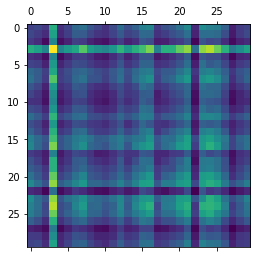

In [154]:
plt.matshow(vizMat)